# 1) Configuración
**Libreta auto-generada — SARIMAX únicamente (Yahoo Finance, descarga por ventanas, Optuna, métricas SOTA)**

In [61]:
# --- Instalación opcional de dependencias (si faltan). Desactiva si prefieres manejarlo tú. ---
ALLOW_PIP = True
def _ensure(pkg, pip_name=None):
    try:
        __import__(pkg)
    except Exception as e:
        if ALLOW_PIP:
            import sys, subprocess
            subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name or pkg])
        else:
            print(f"[WARN] Falta {pkg}. Instálalo manualmente.")
for pkg, pipn in [
    ("yfinance","yfinance"),
    ("pandas","pandas"),
    ("numpy","numpy"),
    ("statsmodels","statsmodels"),
    ("matplotlib","matplotlib"),
    ("tqdm","tqdm"),
    ("pandas_market_calendars","pandas-market-calendars"),
    ("holidays","holidays"),
    ("optuna","optuna")
]:
    _ensure(pkg, pipn)

import os, math, json, warnings, time, traceback
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import optuna
from optuna.pruners import MedianPruner

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera

import pandas_market_calendars as mcal

# --- Parámetros editables ---
TICKER = "BTC-USD"
INTERVAL = "1d"       # "1h","30m","15m","1d", etc.
START = "2023-01-01"          # "2015-01-01" o None
END = None            # "2025-09-08" o None
H = 30                # horizonte de pronóstico en pasos de INTERVAL
REMOVE_HOLIDAYS = False
MARKET_CAL = "XNYS"   # Calendario para limpieza de feriados/horas
TZ = "UTC"            # Zona horaria destino
IMPUTE_MISSING = True
USE_EXOG = True

# Órdenes opcionales (si None, se optimizan con Optuna)
ORDER = None           # p,d,q  e.g., (1,1,1) o None
SEASONAL_ORDER = None  # P,D,Q,m e.g., (0,1,1,24) o None

METRIC_OPT = "sMAPE"   # {"RMSE","MAE","sMAPE","MASE"}
BACKTEST_FOLDS = 3     # 0 para desactivar
N_TRIALS = 1000
TIMEOUT_MIN = 20
N_JOBS = -1
PRUNING = True
RANDOM_SEED = 42

# Carpeta de salida
OUT_DIR = "./outputs"
os.makedirs(OUT_DIR, exist_ok=True)

print("Parámetros activos:")
print(dict(TICKER=TICKER, INTERVAL=INTERVAL, START=START, END=END, H=H,
           REMOVE_HOLIDAYS=REMOVE_HOLIDAYS, MARKET_CAL=MARKET_CAL, TZ=TZ,
           IMPUTE_MISSING=IMPUTE_MISSING, USE_EXOG=USE_EXOG,
           ORDER=ORDER, SEASONAL_ORDER=SEASONAL_ORDER,
           METRIC_OPT=METRIC_OPT, BACKTEST_FOLDS=BACKTEST_FOLDS,
           N_TRIALS=N_TRIALS, TIMEOUT_MIN=TIMEOUT_MIN, N_JOBS=N_JOBS, PRUNING=PRUNING,
           RANDOM_SEED=RANDOM_SEED))

Parámetros activos:
{'TICKER': 'BTC-USD', 'INTERVAL': '1d', 'START': '2023-01-01', 'END': None, 'H': 30, 'REMOVE_HOLIDAYS': False, 'MARKET_CAL': 'XNYS', 'TZ': 'UTC', 'IMPUTE_MISSING': True, 'USE_EXOG': True, 'ORDER': None, 'SEASONAL_ORDER': None, 'METRIC_OPT': 'sMAPE', 'BACKTEST_FOLDS': 3, 'N_TRIALS': 1000, 'TIMEOUT_MIN': 20, 'N_JOBS': -1, 'PRUNING': True, 'RANDOM_SEED': 42}


## 2) Descarga ventana-a-ventana (Yahoo Finance)

In [ ]:
# === 2) Descarga ventana-a-ventana (Yahoo Finance) ===
# Corrige error de tz_localize() con timestamps ya tz-aware (pandas 2.x)

def _allowed_days_and_step(interval: str):
    interval = interval.lower()
    if interval in ("1m","2m"):
        return 30, 5
    if interval in ("5m","15m","30m"):
        return 60, 10
    if interval in ("60m","1h","90m"):
        return 730, 60
    if interval in ("1d","5d","1wk"):
        return 10000, 365*2
    return 3650, 180

def _to_pd_freq(interval: str) -> str:
    m = interval.lower()
    if m.endswith("m"):
        return f"{m[:-1]}min"
    if m.endswith("h"):
        return f"{m[:-1]}H"
    if m.endswith("d"):
        return "D"
    if m.endswith("wk"):
        return "W"
    return "D"

def _to_utc(ts) -> pd.Timestamp:
    ts = pd.Timestamp(ts)
    if ts.tzinfo is None:
        return ts.tz_localize("UTC")
    return ts.tz_convert("UTC")

def download_yf_windowed(ticker: str, interval: str, start=None, end=None, want_max=True, tz="UTC", max_retries=3, sleep=1.0):
    allowed_days, step_days = _allowed_days_and_step(interval)

    # --- Manejo robusto de fechas (compatible pandas 2.x) ---
    if end is None:
        end = pd.Timestamp.now(tz="UTC")  # ya tz-aware
    else:
        end = _to_utc(end)

    if start is None:
        if want_max:
            start = end - pd.Timedelta(days=allowed_days * 50)
        else:
            start = end - pd.Timedelta(days=allowed_days)
    else:
        start = _to_utc(start)

    dfs = []
    cur = start
    pbar = tqdm(total=None, desc=f"Descargando {ticker} {interval} por ventanas")

    while cur < end:
        win_end = min(cur + pd.Timedelta(days=step_days), end)
        retries = 0
        got = None
        while retries <= max_retries:
            try:
                df = yf.download(
                    ticker, interval=interval,
                    start=cur, end=win_end,
                    progress=False, auto_adjust=False, prepost=False, threads=True
                )
                if isinstance(df, pd.DataFrame) and not df.empty:
                    got = df.copy()
                break
            except Exception:
                retries += 1
                time.sleep(sleep * (2 ** retries))
        if got is not None and not got.empty:
            got = got.rename(columns=str.lower)
            if "adj close" in got.columns and "close" not in got.columns and "adj_close" not in got.columns:
                got = got.rename(columns={"adj close": "close"})
            dfs.append(got)
        cur = win_end
        pbar.update(1)

    pbar.close()

    if len(dfs) == 0:
        raise RuntimeError("No se descargaron datos (posible combinación inválida ticker/intervalo).")

    data = pd.concat(dfs).sort_index()
    data = data.loc[~data.index.duplicated(keep="last")]

    # Índice tz-aware -> UTC y luego a tz destino
    if data.index.tz is None:
        data.index = data.index.tz_localize("UTC")
    else:
        data.index = data.index.tz_convert("UTC")
    data = data.tz_convert(tz)

    # Mantener columnas OHLCV
    cols = [c for c in ["open","high","low","close","volume"] if c in data.columns]
    data = data[cols].astype(float)
    return data

raw = download_yf_windowed(TICKER, INTERVAL, START, END, want_max=True, tz=TZ)
print(raw.tail(3))
print(raw.index[0], "->", raw.index[-1], f"({len(raw)} filas)")


Descargando BTC-USD 1d por ventanas: 2it [00:00,  8.62it/s]

Price                               open           high            low  \
Ticker                           btc-usd        btc-usd        btc-usd   
Date                                                                     
2025-09-06 00:00:00+00:00  110650.570312  111275.015625  110024.085938   
2025-09-07 00:00:00+00:00  110221.328125  111591.078125  110211.625000   
2025-09-08 00:00:00+00:00  111142.382812  112849.140625  110693.453125   

Price                              close        volume  
Ticker                           btc-usd       btc-usd  
Date                                                    
2025-09-06 00:00:00+00:00  110224.695312  2.150072e+10  
2025-09-07 00:00:00+00:00  111167.617188  2.461801e+10  
2025-09-08 00:00:00+00:00  112215.859375  4.058743e+10  
2023-01-01 00:00:00+00:00 -> 2025-09-08 00:00:00+00:00 (982 filas)


## 3) Limpieza / Calendario (frecuencia fija, imputación, feriados)

In [63]:
def fix_frequency(df: pd.DataFrame, interval: str, impute=True):
    freq = _to_pd_freq(interval)
    # Reindex a rejilla completa
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq=freq, tz=df.index.tz)
    out = df.reindex(full_idx)
    # Imputación simple
    if impute:
        out["close"] = out["close"].ffill()
        for c in ["open","high","low","volume"]:
            if c in out.columns:
                if c == "volume":
                    out[c] = out[c].fillna(0.0)
                else:
                    out[c] = out[c].fillna(method="ffill").fillna(out["close"])
    return out

def filter_market_sessions(df: pd.DataFrame, interval: str, cal_name="XNYS"):
    # Solo intradía
    if interval.lower().endswith(("m","h")):
        cal = mcal.get_calendar(cal_name)
        freq = _to_pd_freq(interval)
        sched = cal.schedule(start_date=df.index.min().date() - pd.Timedelta(days=7),
                             end_date=df.index.max().date() + pd.Timedelta(days=7))
        # Genera rango de sesiones con la misma frecuencia
        trade_idx = mcal.date_range(sched, frequency=freq, force_close=True)
        # Asegura misma zona
        trade_idx = trade_idx.tz_convert(df.index.tz)
        # Reindex para remover fuera de sesión/feriados
        df2 = df.reindex(trade_idx)
        return df2
    return df

data = fix_frequency(raw, INTERVAL, impute=IMPUTE_MISSING)
if REMOVE_HOLIDAYS:
    data = filter_market_sessions(data, INTERVAL, MARKET_CAL)

print(data.tail(3))

Price                               open           high            low  \
Ticker                           btc-usd        btc-usd        btc-usd   
2025-09-06 00:00:00+00:00  110650.570312  111275.015625  110024.085938   
2025-09-07 00:00:00+00:00  110221.328125  111591.078125  110211.625000   
2025-09-08 00:00:00+00:00  111142.382812  112849.140625  110693.453125   

Price                              close        volume  
Ticker                           btc-usd       btc-usd  
2025-09-06 00:00:00+00:00  110224.695312  2.150072e+10  
2025-09-07 00:00:00+00:00  111167.617188  2.461801e+10  
2025-09-08 00:00:00+00:00  112215.859375  4.058743e+10  


## 4) Split + (opcional) Backtesting (rolling origin)

In [64]:
def make_exog(idx: pd.DatetimeIndex):
    # Dummies de hora/día (sin colinealidad)
    df = pd.DataFrame(index=idx)
    if any(k in INTERVAL for k in ["m","h"]):
        df["hour"] = idx.hour
        ex_hour = pd.get_dummies(df["hour"], prefix="hr", drop_first=True, dtype=float)
    else:
        ex_hour = pd.DataFrame(index=idx)
    df["dow"] = idx.dayofweek
    ex_dow = pd.get_dummies(df["dow"], prefix="dow", drop_first=True, dtype=float)
    ex = pd.concat([ex_hour, ex_dow], axis=1)
    if ex.shape[1] == 0:
        ex["bias"] = 1.0
    return ex

def simple_split(y: pd.Series, test_h: int, val_frac=0.15):
    n = len(y)
    test_start = n - test_h
    val_end = test_start
    val_start = max(0, int(val_end - n*val_frac))
    train = y.iloc[:val_start]
    val = y.iloc[val_start:val_end]
    test = y.iloc[test_start:]
    return train, val, test

def rolling_origin_splits(y: pd.Series, folds: int, val_len: int):
    # Ventanas crecientes, validación fija val_len
    starts = np.linspace(len(y)*0.5, len(y)-val_len*1.5, num=folds).astype(int)
    for s in starts:
        tr = y.iloc[:s]
        va = y.iloc[s:s+val_len]
        yield tr, va

y = data["close"].astype(float).copy()
train, val, test = simple_split(y, test_h=H, val_frac=0.15)

EXOG_ON_DEFAULT = USE_EXOG
exog_all = make_exog(y.index) if USE_EXOG else None
exog_train = exog_all.loc[train.index] if exog_all is not None else None
exog_val = exog_all.loc[val.index] if exog_all is not None else None
exog_test = exog_all.loc[test.index] if exog_all is not None else None

print(f"Tamaños -> train:{len(train)} val:{len(val)} test:{len(test)} | Último índice train:{train.index[-1]}")

Tamaños -> train:804 val:148 test:30 | Último índice train:2025-03-14 00:00:00+00:00


## 5) Hypertuning con Optuna (minimiza métrica en validación o promedio de folds)

In [65]:
# === 5) Hypertuning con Optuna (versión rápida) ===
# Acelera el tiempo de búsqueda con:
# - Submuestreo del set de entrenamiento para trials
# - Menor longitud de validación en folds
# - Pruning agresivo
# - Máx. iteraciones por trial más bajas (fit)
# - Diferenciado simple (simple_differencing) y concentrate_scale
# - (Opcional) Sugeridor con pmdarima para reducir el espacio de búsqueda (NO entrena con pmdarima)

# ----- Opciones de aceleración -----
FAST_OPT = True                   # activa heurísticas de velocidad
TRAIN_SUBSAMPLE_FRAC = 0.50       # usa el 50% más reciente del set para trials
VAL_FRAC_FOR_TRIALS = 0.05        # validación corta por trial (5% del total)
MAXITER_TRIAL = 60                # menos iteraciones del optimizador por trial
USE_PMDARIMA_SUGGESTOR = True     # usa pmdarima SOLO para sugerir (si está instalado)
AGGRESSIVE_PRUNING = True         # pruning más agresivo

rng = np.random.default_rng(RANDOM_SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# --- Métricas ---
def smape(y_true, y_pred, eps=1e-8):
    a = np.abs(y_pred - y_true)
    b = (np.abs(y_true) + np.abs(y_pred)) / 2.0 + eps
    return float(np.mean(a / b))

def mase(y_true, y_pred, y_train, m=1):
    if len(y_train) <= 1:
        return np.nan
    naive_diff = np.abs(np.diff(y_train, n=m)).mean()
    return float(np.mean(np.abs(y_true - y_pred)) / (naive_diff + 1e-8))

def metric_value(name, y_true, y_pred, y_train=None):
    name = name.upper()
    if name == "RMSE":
        return float(np.sqrt(np.mean((y_true - y_pred)**2)))
    if name == "MAE":
        return float(np.mean(np.abs(y_true - y_pred)))
    if name == "SMAPE":
        return smape(y_true, y_pred)
    if name == "MASE":
        return mase(y_true, y_pred, y_train if y_train is not None else y_true, m=1)
    return smape(y_true, y_pred)

# --- Estacionales candidatos por intervalo ---
def seasonal_candidates(interval: str):
    m = interval.lower()
    if m == "1h":
        return [24, 24*7]
    if m == "30m":
        return [48, 48*7]
    if m == "15m":
        return [96, 96*7]
    if m == "1d":
        return [7, 30, 365]
    return [0, 7]

# --- Sugeridor opcional pmdarima para acotar espacio ---
pm_suggest = {"p": None, "d": None, "q": None, "P": 0, "D": 0, "Q": 0, "m": 0}
if USE_PMDARIMA_SUGGESTOR:
    try:
        import pmdarima as pmd
        # Estimar d y D (con el m más plausible)
        m_cands = seasonal_candidates(INTERVAL)
        m0 = max([m for m in m_cands if m > 0], default=0)
        d0 = pmd.arima.ndiffs(y, test="kpss", alpha=0.05, max_d=2)
        D0 = pmd.arima.nsdiffs(y, m=m0, test="ocsb", max_D=1) if m0 > 0 else 0
        # Auto-sugerencia rápida (no entrenamos final con esto)
        try:
            a = pmd.arima.auto_arima(
                y if not USE_EXOG else y,  # exog solo complica; omitimos para velocidad
                seasonal=(m0 > 0), m=m0, d=d0, D=D0,
                max_p=3, max_q=3, max_P=2, max_Q=2,
                information_criterion="aic", error_action="ignore", suppress_warnings=True,
                stepwise=True, with_intercept=True, maxiter=50
            )
            ord_ = a.order; seas_ = a.seasonal_order
            pm_suggest.update({"p": ord_[0], "d": d0, "q": ord_[2], "P": seas_[0], "D": D0, "Q": seas_[2], "m": seas_[3]})
        except Exception:
            pm_suggest.update({"d": d0, "D": D0, "m": m0})
    except Exception:
        pass

# --- Submuestreo para trials (usa tramo reciente) ---
if FAST_OPT:
    n_tail = max(int(len(y) * TRAIN_SUBSAMPLE_FRAC), 200)
    y_opt = y.iloc[-n_tail:].copy()
else:
    y_opt = y

# --- Exógenas on/off controlado por Optuna ---
def make_exog(idx: pd.DatetimeIndex):
    df = pd.DataFrame(index=idx)
    if any(k in INTERVAL for k in ["m","h"]):
        df["hour"] = idx.hour
        ex_hour = pd.get_dummies(df["hour"], prefix="hr", drop_first=True, dtype=float)
    else:
        ex_hour = pd.DataFrame(index=idx)
    df["dow"] = idx.dayofweek
    ex_dow = pd.get_dummies(df["dow"], prefix="dow", drop_first=True, dtype=float)
    ex = pd.concat([ex_hour, ex_dow], axis=1)
    if ex.shape[1] == 0:
        ex["bias"] = 1.0
    return ex

# --- Splits para trials (validación corta) ---
def rolling_origin_splits(y_series: pd.Series, folds: int, val_len: int):
    starts = np.linspace(len(y_series)*0.5, len(y_series)-val_len*1.5, num=folds).astype(int)
    for s in starts:
        tr = y_series.iloc[:s]
        va = y_series.iloc[s:s+val_len]
        yield tr, va

val_len_trials = max(H, int(len(y_opt) * (VAL_FRAC_FOR_TRIALS if FAST_OPT else 0.10)))

# --- Caché de evaluaciones para evitar recomputar mismos params ---
SCORE_CACHE = {}

def build_and_score(y_tr, y_va, ex_tr, ex_va, params, fit_maxiter=MAXITER_TRIAL):
    key = (
        tuple(params["order"]),
        tuple(params["seasonal_order"]),
        params["trend"],
        params["enforce_stationarity"],
        params["enforce_invertibility"],
        ex_tr is not None
    )
    if key in SCORE_CACHE:
        return SCORE_CACHE[key], None
    try:
        mod = SARIMAX(
            y_tr, exog=ex_tr,
            order=tuple(params["order"]),
            seasonal_order=tuple(params["seasonal_order"]),
            trend=params["trend"],
            enforce_stationarity=params["enforce_stationarity"],
            enforce_invertibility=params["enforce_invertibility"],
            simple_differencing=True  # acelera con d/D>0
        )
        res = mod.fit(disp=False, method="lbfgs", maxiter=fit_maxiter, concentrate_scale=True)
        fc = res.get_forecast(steps=len(y_va), exog=ex_va)
        pred = pd.Series(fc.predicted_mean, index=y_va.index).astype(float)
        val = metric_value(METRIC_OPT, y_va.values, pred.values, y_tr.values)
    except Exception:
        val, res = 1e12, None
    SCORE_CACHE[key] = val
    return val, res

# --- Búsqueda Optuna (espacio reducido) ---
def objective(trial: optuna.Trial):
    # Rango reducido alrededor de la sugerencia pmdarima (si disponible)
    def _bounded_int(name, center, lo, hi, wiggle=1):
        if center is None:
            return trial.suggest_int(name, lo, hi)
        return trial.suggest_int(name, max(lo, center - wiggle), min(hi, center + wiggle))

    p = _bounded_int("p", pm_suggest["p"], 0, 5, wiggle=1 if FAST_OPT else 2)
    d = _bounded_int("d", pm_suggest["d"], 0, 2, wiggle=0 if FAST_OPT else 1)
    q = _bounded_int("q", pm_suggest["q"], 0, 5, wiggle=1 if FAST_OPT else 2)

    seas_m_list = seasonal_candidates(INTERVAL)
    if len(seas_m_list) and max(seas_m_list) > 0:
        P = _bounded_int("P", pm_suggest["P"], 0, 2, wiggle=0 if FAST_OPT else 1)
        D = _bounded_int("D", pm_suggest["D"], 0, 1, wiggle=0)
        m = trial.suggest_categorical("m", seas_m_list if not FAST_OPT else list({pm_suggest["m"] or seas_m_list[0], seas_m_list[0]}))
        Q = _bounded_int("Q", pm_suggest["Q"], 0, 2, wiggle=0 if FAST_OPT else 1)
    else:
        P = D = Q = 0
        m = 0

    trend = trial.suggest_categorical("trend", ["n","c"] if FAST_OPT else ["n","c","t","ct"])
    ex_on = trial.suggest_categorical("EXOG_ON", [1, 0]) if USE_EXOG else 0
    enforce_stat = trial.suggest_categorical("enforce_stationarity", [True, False] if not FAST_OPT else [True])
    enforce_inv = trial.suggest_categorical("enforce_invertibility", [True, False] if not FAST_OPT else [True])

    params = dict(
        order=(p,d,q),
        seasonal_order=(P,D,Q,m),
        trend=trend,
        enforce_stationarity=enforce_stat,
        enforce_invertibility=enforce_inv
    )

    # Folds (si BACKTEST_FOLDS>0) pero con val_len reducido
    if BACKTEST_FOLDS and BACKTEST_FOLDS > 0:
        scores = []
        for i, (y_tr, y_va) in enumerate(rolling_origin_splits(y_opt, BACKTEST_FOLDS, val_len_trials)):
            ex_tr = make_exog(y_tr.index) if (USE_EXOG and ex_on==1) else None
            ex_va = make_exog(y_va.index) if (USE_EXOG and ex_on==1) else None
            sc, _ = build_and_score(y_tr, y_va, ex_tr, ex_va, params, fit_maxiter=MAXITER_TRIAL)
            trial.report(sc, step=i)
            if (PRUNING or AGGRESSIVE_PRUNING) and trial.should_prune():
                raise optuna.TrialPruned()
            scores.append(sc)
        return float(np.mean(scores))
    else:
        # Split simple (usa últimos segmentos de y_opt)
        n = len(y_opt)
        val_len = val_len_trials
        tr = y_opt.iloc[: n - val_len]
        va = y_opt.iloc[n - val_len :]
        ex_tr = make_exog(tr.index) if (USE_EXOG and ex_on==1) else None
        ex_va = make_exog(va.index) if (USE_EXOG and ex_on==1) else None
        sc, _ = build_and_score(tr, va, ex_tr, ex_va, params, fit_maxiter=MAXITER_TRIAL)
        return sc

# --- Estudio Optuna (TPE multivariado + pruning agresivo) ---
sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED, multivariate=True, consider_endpoints=True)
pruner = MedianPruner(n_startup_trials=max(5, N_TRIALS//6)) if (PRUNING or AGGRESSIVE_PRUNING) else optuna.pruners.NopPruner()

study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)
study.optimize(
    objective,
    n_trials=N_TRIALS,
    timeout=TIMEOUT_MIN*60,
    n_jobs=N_JOBS,
    show_progress_bar=True
)

best_params = study.best_trial.params
print("Mejor métrica (", METRIC_OPT, "):", study.best_value)
print("Mejores params:", best_params)

# Guardar resultados Optuna
with open(os.path.join(OUT_DIR, "best_params.json"), "w") as f:
    json.dump(best_params, f, indent=2)

df_trials = study.trials_dataframe()
df_trials.to_csv(os.path.join(OUT_DIR, "trials.csv"), index=False)

# Plots (si kaleido disponible)
try:
    fig1 = optuna.visualization.plot_optimization_history(study)
    fig1.write_image(os.path.join(OUT_DIR, "opt_history.png"))
except Exception:
    pass
try:
    fig2 = optuna.visualization.plot_param_importances(study)
    fig2.write_image(os.path.join(OUT_DIR, "opt_importances.png"))
except Exception:
    pass
try:
    fig3 = optuna.visualization.plot_slice(study)
    fig3.write_image(os.path.join(OUT_DIR, "opt_slice.png"))
except Exception:
    pass


Best trial: 34. Best value: 0.0404028: 100%|██████████| 1000/1000 [01:04<00:00, 15.59it/s, 64.14/1200 seconds]


Mejor métrica ( sMAPE ): 0.04040276276171314
Mejores params: {'p': 3, 'd': 0, 'q': 2, 'P': 0, 'D': 0, 'm': 7, 'Q': 0, 'trend': 'n', 'EXOG_ON': 0, 'enforce_stationarity': True, 'enforce_invertibility': True}


## 6) Entrenamiento final con mejores hiperparámetros

In [66]:
def params_from_best(best: dict):
    p = best.get("p", 1)
    d = best.get("d", 1)
    q = best.get("q", 1)
    P = best.get("P", 0)
    D = best.get("D", 0)
    Q = best.get("Q", 0)
    m = best.get("m", 0)
    trend = best.get("trend", "c")
    enforce_stationarity = best.get("enforce_stationarity", True)
    enforce_invertibility = best.get("enforce_invertibility", True)
    return dict(order=(p,d,q), seasonal_order=(P,D,Q,m), trend=trend,
                enforce_stationarity=enforce_stationarity, enforce_invertibility=enforce_invertibility)

final_params = params_from_best(best_params) if ORDER is None or SEASONAL_ORDER is None else dict(order=ORDER, seasonal_order=SEASONAL_ORDER, trend=best_params.get("trend","c"), enforce_stationarity=True, enforce_invertibility=True)

# Entrenar con TRAIN+VAL para aprovechar más datos
y_fit = pd.concat([train, val])
ex_fit = make_exog(y_fit.index) if USE_EXOG and best_params.get("EXOG_ON", 1)==1 else (make_exog(y_fit.index) if USE_EXOG and (ORDER is not None or SEASONAL_ORDER is not None) else None)

model = SARIMAX(y_fit, exog=ex_fit, **final_params)
res = model.fit(disp=False)
summary_text = str(res.summary())
print(summary_text.splitlines()[:15])

# Guardar resumen AIC/BIC
with open(os.path.join(OUT_DIR, "summary.txt"), "w", encoding="utf-8") as f:
    f.write(summary_text)
    f.write("\n\nAIC=" + str(res.aic) + "  BIC=" + str(res.bic))
print("AIC:", res.aic, "BIC:", res.bic)

['                               SARIMAX Results                                ', '==============================================================================', 'Dep. Variable:                btc-usd   No. Observations:                  952', 'Model:               SARIMAX(3, 0, 2)   Log Likelihood               -8374.411', 'Date:                Mon, 08 Sep 2025   AIC                          16760.823', 'Time:                        16:58:27   BIC                          16789.974', 'Sample:                    01-01-2023   HQIC                         16771.929', '                         - 08-09-2025                                         ', 'Covariance Type:                  opg                                         ', '==============================================================================', '                 coef    std err          z      P>|z|      [0.025      0.975]', '------------------------------------------------------------------------------', 'ar.L1         

## 7) Pronóstico + intervalos (80% y 95%)

In [67]:
# === 7) Pronóstico + intervalos (80% y 95%) — versión robusta (Series/DataFrame) ===
def _to_1d(series_like):
    arr = np.asarray(series_like)
    if arr.ndim > 1:
        arr = np.ravel(arr)
    return arr

ex_future = make_exog(test.index) if USE_EXOG and (best_params.get("EXOG_ON", 1)==1 or (ORDER is not None or SEASONAL_ORDER is not None)) else None
fc = res.get_forecast(steps=len(test), exog=ex_future)
pred = pd.Series(_to_1d(fc.predicted_mean), index=test.index, name="y_pred").astype(float)

# Intervalos de confianza (acepta DataFrame o ndarray)
ci80 = fc.conf_int(alpha=0.2)
ci95 = fc.conf_int(alpha=0.05)

def _ci_bounds(ci, idx, names=("lower","upper")):
    if isinstance(ci, pd.DataFrame):
        lo = pd.Series(ci.iloc[:, 0].to_numpy(), index=idx, name=names[0])
        up = pd.Series(ci.iloc[:, 1].to_numpy(), index=idx, name=names[1])
    else:
        arr = np.asarray(ci)
        if arr.ndim == 1:  # algunos returns pueden venir aplanados
            mid = len(arr)//2
            lo = pd.Series(arr[:mid], index=idx, name=names[0])
            up = pd.Series(arr[mid:], index=idx, name=names[1])
        else:
            lo = pd.Series(arr[:, 0], index=idx, name=names[0])
            up = pd.Series(arr[:, 1], index=idx, name=names[1])
    return lo, up

lower80, upper80 = _ci_bounds(ci80, test.index, names=("lower80","upper80"))
lower95, upper95 = _ci_bounds(ci95, test.index, names=("lower95","upper95"))

# y_true como Serie 1D asegurada
y_true_index = test.index if hasattr(test, "index") else pred.index
y_true_vals = _to_1d(test if isinstance(test, (pd.Series, pd.DataFrame)) else np.asarray(test))
y_true_s = pd.Series(y_true_vals, index=y_true_index, name="y_true")

forecast_df = pd.concat([y_true_s, pred, lower80, upper80, lower95, upper95], axis=1)
forecast_df.to_csv(os.path.join(OUT_DIR, "forecast.csv"))
forecast_df.tail(3)


,y_true,y_pred,lower80,upper80,lower95,upper95
2025-09-06 00:00:00+00:00,110224.695312,115890.676296,105407.541763,126373.810829,99858.105557,131923.247035
2025-09-07 00:00:00+00:00,111167.617188,115866.846356,105199.124636,126534.568075,99551.973877,132181.718835
2025-09-08 00:00:00+00:00,112215.859375,115848.213546,104999.716985,126696.710107,99256.869806,132439.557286


## 8) Métricas (MAE, RMSE, MAPE, sMAPE, MASE) + Coberturas

In [68]:
def mape(y_true, y_pred, eps=1e-8):
    return float(np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100.0)

def coverage(y_true, lo, up):
    inside = ((y_true >= lo) & (y_true <= up)).mean()
    return float(inside)

y_true = forecast_df["y_true"].values
y_pred = forecast_df["y_pred"].values

metrics = {
    "MAE": float(np.mean(np.abs(y_true - y_pred))),
    "RMSE": float(np.sqrt(np.mean((y_true - y_pred)**2))),
    "MAPE": mape(y_true, y_pred),
    "sMAPE": smape(y_true, y_pred),
    "MASE": mase(y_true, y_pred, y_fit.values, m=1),
    "COV80": coverage(y_true, forecast_df["lower80"].values, forecast_df["upper80"].values),
    "COV95": coverage(y_true, forecast_df["lower95"].values, forecast_df["upper95"].values),
    "WIDTH80": float(np.mean(forecast_df["upper80"].values - forecast_df["lower80"].values)),
    "WIDTH95": float(np.mean(forecast_df["upper95"].values - forecast_df["lower95"].values)),
}
print(metrics)

with open(os.path.join(OUT_DIR, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

{'MAE': 3874.3001637577936, 'RMSE': 4444.91405546568, 'MAPE': 3.4500440262835745, 'sMAPE': 0.03391632464375836, 'MASE': nan, 'COV80': 0.9, 'COV95': 0.9666666666666667, 'WIDTH80': 14834.531863828788, 'WIDTH95': 22687.458673003657}


## 9) Gráficas (serie, bandas 80/95, líneas train/val/test)

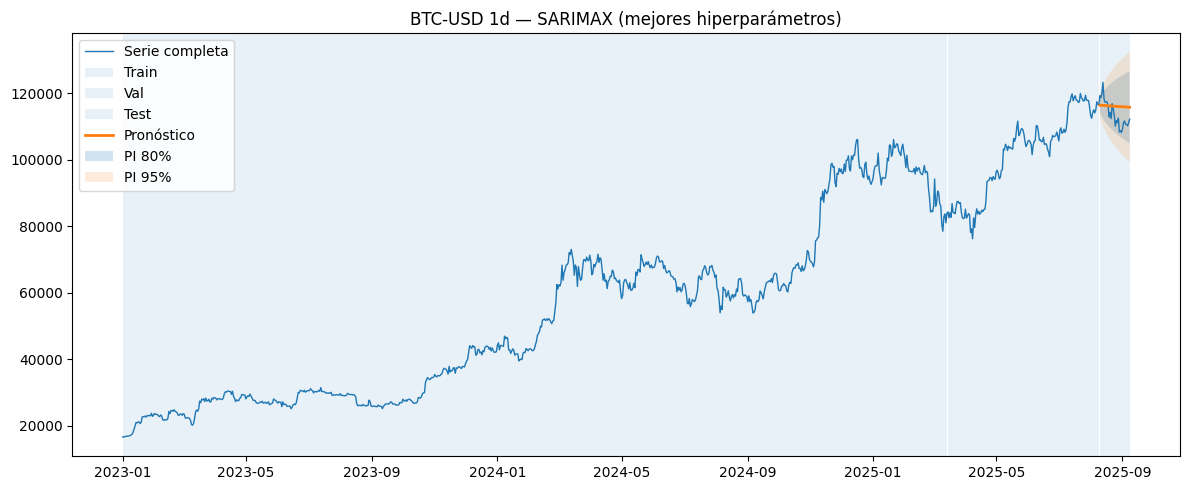

In [69]:
plt.figure(figsize=(12,5))
plt.plot(y.index, y.values, label="Serie completa", linewidth=1)
plt.axvspan(train.index[0], train.index[-1], alpha=0.1, label="Train")
plt.axvspan(val.index[0], val.index[-1], alpha=0.1, label="Val")
plt.axvspan(test.index[0], test.index[-1], alpha=0.1, label="Test")
plt.plot(forecast_df.index, forecast_df["y_pred"], label="Pronóstico", linewidth=2)
plt.fill_between(forecast_df.index, forecast_df["lower80"], forecast_df["upper80"], alpha=0.2, label="PI 80%")
plt.fill_between(forecast_df.index, forecast_df["lower95"], forecast_df["upper95"], alpha=0.15, label="PI 95%")
plt.title(f"{TICKER} {INTERVAL} — SARIMAX (mejores hiperparámetros)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "plot_forecast.png"), dpi=140)
plt.show()

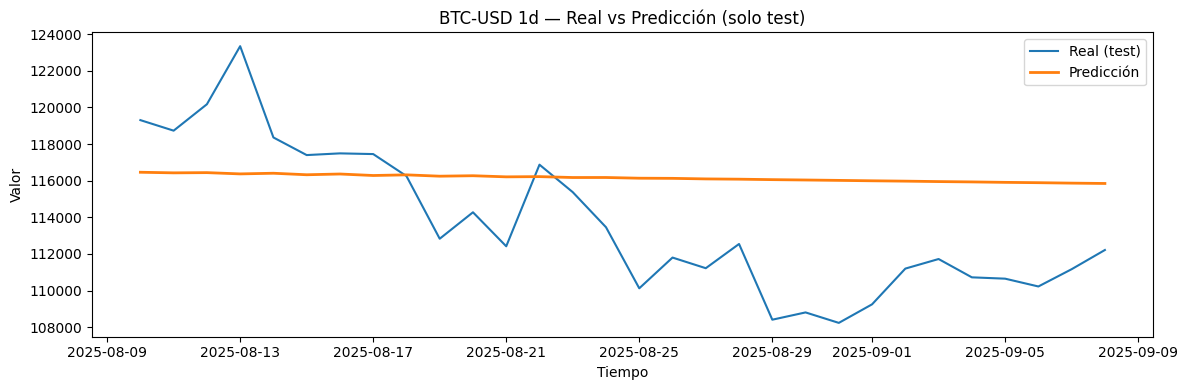

In [70]:
# === 9-b) Gráfica SOLO del tramo de test: valor real vs predicción (sin históricos) ===
# Requiere que 'forecast_df' exista con columnas ['y_true','y_pred'] y que OUT_DIR esté definido.

import matplotlib.pyplot as plt
import os

if "forecast_df" not in globals():
    raise RuntimeError("No existe 'forecast_df'. Ejecuta antes la celda de pronóstico para crearla.")

plt.figure(figsize=(12,4))
plt.plot(forecast_df.index, forecast_df["y_true"], label="Real (test)", linewidth=1.5)
plt.plot(forecast_df.index, forecast_df["y_pred"], label="Predicción", linewidth=2)
plt.title(f"{TICKER} {INTERVAL} — Real vs Predicción (solo test)")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.legend()
plt.tight_layout()
os.makedirs(OUT_DIR, exist_ok=True)
plt.savefig(os.path.join(OUT_DIR, "plot_test_only.png"), dpi=140)
plt.show()


## 10) Diagnósticos (residuales, QQ, ACF/PACF, Ljung-Box, normalidad)

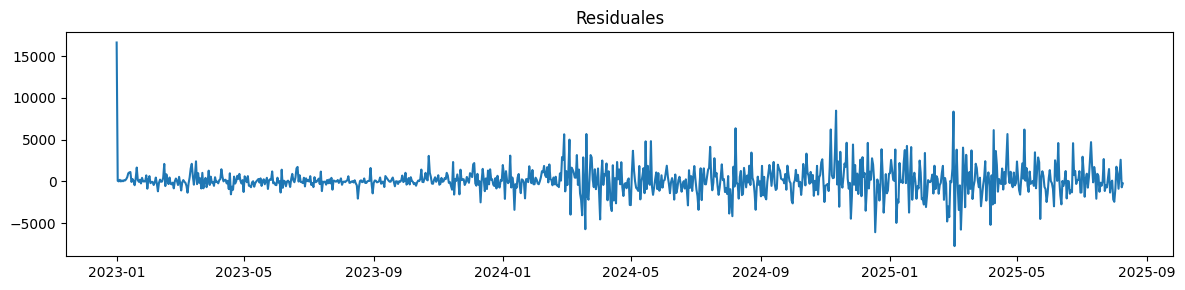

<Figure size 500x400 with 0 Axes>

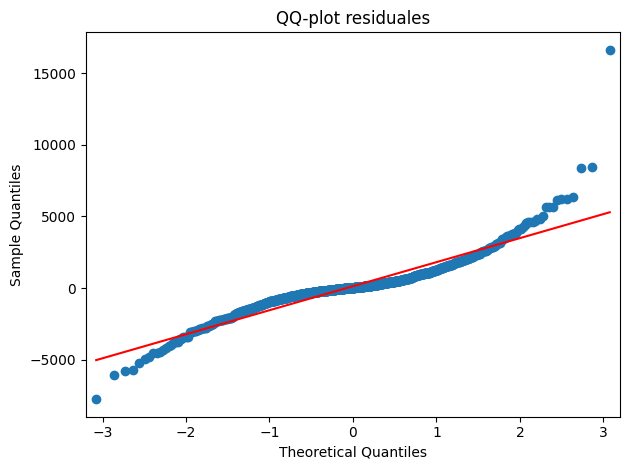

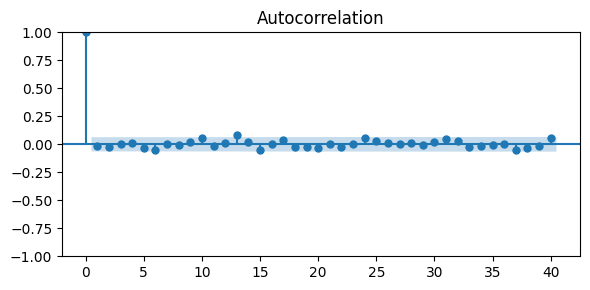

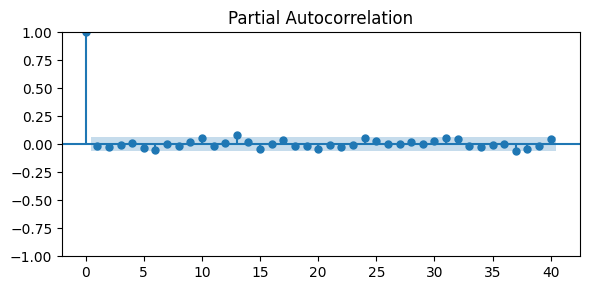

Ljung-Box p-values:
 10    0.631920
20    0.389601
30    0.649638
Name: lb_pvalue, dtype: float64
Jarque-Bera p-value: 0.0000


In [71]:
resid = res.resid.dropna()

plt.figure(figsize=(12,3))
plt.plot(resid)
plt.title("Residuales")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "diag_residuals.png"), dpi=140)
plt.show()

plt.figure(figsize=(5,4))
qqplot(resid, line="s")
plt.title("QQ-plot residuales")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "diag_qq.png"), dpi=140)
plt.show()

fig, ax = plt.subplots(1,1, figsize=(6,3))
plot_acf(resid, ax=ax, lags=40)
fig.tight_layout(); fig.savefig(os.path.join(OUT_DIR, "diag_acf.png"), dpi=140); plt.show()

fig, ax = plt.subplots(1,1, figsize=(6,3))
plot_pacf(resid, ax=ax, lags=40, method="ywm")
fig.tight_layout(); fig.savefig(os.path.join(OUT_DIR, "diag_pacf.png"), dpi=140); plt.show()

lb = acorr_ljungbox(resid, lags=[10,20,30], return_df=True)
jb_stat, jb_p, _, _ = jarque_bera(resid)
print("Ljung-Box p-values:\n", lb["lb_pvalue"])
print(f"Jarque-Bera p-value: {jb_p:.4f}")

## 11) Guardado final y versiones

In [72]:
# Ya guardamos: forecast.csv, metrics.json, plot_forecast.png, summary.txt, trials.csv, best_params.json
# Datos limpios
data.to_csv(os.path.join(OUT_DIR, "datos_limpios.csv"))

# Versions
import importlib, sys
def _v(pkg): 
    try: return importlib.import_module(pkg).__version__
    except: return "NA"
versions = {
    "python": sys.version,
    "pandas": _v("pandas"),
    "numpy": _v("numpy"),
    "statsmodels": _v("statsmodels"),
    "matplotlib": _v("matplotlib"),
    "yfinance": _v("yfinance"),
    "optuna": _v("optuna"),
    "pandas_market_calendars": _v("pandas_market_calendars")
}
with open(os.path.join(OUT_DIR, "versions.json"), "w") as f:
    json.dump(versions, f, indent=2)
print("Versiones:", versions)
print("Archivos guardados en:", os.path.abspath(OUT_DIR))

Versiones: {'python': '3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]', 'pandas': '2.3.2', 'numpy': '2.2.6', 'statsmodels': '0.14.5', 'matplotlib': '3.10.6', 'yfinance': '0.2.65', 'optuna': '4.5.0', 'pandas_market_calendars': '5.1.1'}
Archivos guardados en: c:\Users\Administrator\Desktop\PROYECTOS\FORECASTING\FORECASTING\outputs
